In [1]:
import os
import rasterio
from rasterio import features
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.transform import xy
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point
from shapely.ops import nearest_points, transform
from pyproj import Transformer
import matplotlib.pyplot as plt
from skimage import measure
import numpy as np
import math
from kneed import KneeLocator

In [2]:
%matplotlib inline

In [3]:
def open_raster(file_path):
    """
    Open and read a raster file using the rasterio library.

    Parameters:
    - file_path (str): Path to the raster file.

    Returns:
    - Tuple[numpy.ndarray, Affine, CRS]: A tuple containing:
      - numpy.ndarray: Raster data.
      - Affine: Transformation information.
      - CRS: Coordinate Reference System information.

    The function uses the rasterio library to open the raster file specified by the `file_path`.
    It reads the raster data, transformation information, and CRS (Coordinate Reference System),
    and returns them as a tuple.
    """
    with rasterio.open(file_path) as src:
        raster = src.read(1)
        transform = src.transform
        crs = src.crs
    return raster, transform, crs

In [4]:
def show_raster(raster):
    fig, ax = plt.subplots()
    show(raster, ax=ax)

In [5]:
file_path = r'C:\Users\somadder\Thesis\CP\CP.tif'

In [6]:
current_dir = os.path.dirname(file_path)
os.chdir(current_dir)

In [7]:
dem, transform, crs = open_raster(file_path=file_path)

In [8]:
peak_gdf = gpd.read_file('cp_30m_p3_peaks.shp')

In [9]:
region_gdf = gpd.read_file('cp_30m_p3_regions.shp')

In [10]:
region_gdf['area'] = region_gdf.geometry.area

In [11]:
region_gdf = region_gdf[(region_gdf['area'] >= 120000) & (region_gdf['area'] <= 10000000)]

In [18]:
out_shp_path = 'cp_peak_boundaries_test.shp'
with rasterio.open(file_path) as src:
    # raster = src.read(1)
    # transform = src.transform
    crs = src.crs
    nodata = src.nodata
    out_meta = src.meta.copy()
    for region_idx, region_row in region_gdf.iterrows():
        if region_row.peak_id != '433_1312':
            continue
        
        region_geom = region_row.geometry
        region_bounds = region_geom.bounds
        clipped_raster, clipped_transform = mask(src, [region_geom], crop=True)
        
        valid_raster = clipped_raster[clipped_raster != nodata]
        min_value = (np.ceil(valid_raster.min() / 5) * 5).astype(int)
        max_value = (np.floor_divide(valid_raster.max(), 5) * 5).astype(int)

        contour_data = []
        for level in range(min_value, max_value+5, 5):
            contours = measure.find_contours(clipped_raster[0], level)
            contour_coords = [coord[:, [1, 0]] for coord in contours]
            georef_coords = [np.array([xy(clipped_transform, col, row) for row, col in coord]) for coord in contour_coords]
            contour_geoms = []
            for coords in georef_coords:
                if len(coords) >=4:
                    contour_geoms.append(Polygon(coords))
                else:
                    continue
            contour_geoms = [geom for geom in contour_geoms if geom.is_valid]
            contour_data.extend([(geom, level) for geom in contour_geoms])

        contour_gdf = gpd.GeoDataFrame(contour_data, columns=['geometry', 'level'], crs=crs)

        peak_point = peak_gdf[peak_gdf['peak_id']==region_row.peak_id].geometry
        contour_gdf['peak_contains'] = contour_gdf.geometry.apply(lambda geom: geom.contains(peak_point))
        contour_gdf = contour_gdf[contour_gdf['peak_contains']==1]
        contour_gdf['line'] = contour_gdf.boundary
        contour_gdf['boundary_d'] = contour_gdf.line.apply(lambda geom: min([peak_point.distance(geom)]))

        with rasterio.open('CP_Slope.tif') as slope_src:
            for contour_idx, contour_row in contour_gdf.iterrows():
                line = contour_row.line
                out_slope, out_trans = mask(slope_src, [line], crop=True, filled=True, nodata=-999)
                out_slope_array = out_slope.flatten()
                only_masked_pixels = np.delete(out_slope_array, np.where(out_slope_array == -999))
                if len(only_masked_pixels) > 0:
                    min_slope = np.min(only_masked_pixels)
                    max_slope = np.max(only_masked_pixels)
                    avg_slope = np.average(only_masked_pixels)
                    contour_gdf.at[contour_idx, 'slope_min'] = min_slope
                    contour_gdf.at[contour_idx, 'slope_max'] = max_slope
                    contour_gdf.at[contour_idx, 'slope_avg'] = avg_slope
        
        if len(contour_gdf) == 0:
            continue
        contour_gdf = contour_gdf.drop(['line', 'peak_contains'], axis=1)
        contour_gdf = contour_gdf.sort_values(by='boundary_d')
        x = contour_gdf['boundary_d']
        y = contour_gdf['level']
        kn = KneeLocator(x, y, curve='convex', direction='decreasing')
        convex_elbow_point = kn.knee
        kn_concave = KneeLocator(x, y, curve='concave', direction='decreasing')
        concave_elbow_point = kn_concave.knee
        bounds_df = contour_gdf[(contour_gdf['boundary_d'] == convex_elbow_point) | (contour_gdf['boundary_d'] == concave_elbow_point)]
        bounds_df['peak_id'] = region_row.peak_id
        if len(bounds_df) == 0:
            continue
        if os.path.exists(out_shp_path):
            bounds_df.to_file(out_shp_path, driver='ESRI Shapefile', crs=crs, mode='a')
        else:
            bounds_df.to_file(out_shp_path, driver='ESRI Shapefile', crs=crs)
        contour_gdf.to_file('temp/d.shp',driver='ESRI Shapefile', crs=crs)

C:\Users\somadder\.conda\envs\thesis\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [99]:
len(contour_coords)

4

In [178]:
contour_gdf = contour_gdf.sort_values(by='level')

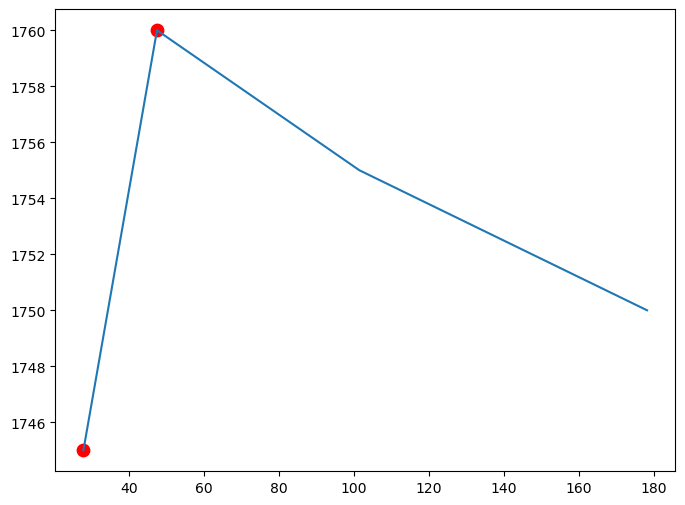

In [19]:
x = contour_gdf['boundary_d']
y = contour_gdf['level']
derivative = np.gradient(y, x)
max = np.abs(derivative).max()
threshold = max - max * .5
significant_points = np.where(np.abs(derivative) > threshold)[0]
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y)
ax.scatter(x.iloc[significant_points], y.iloc[significant_points], color='r', marker='o', s=80)

In [20]:
contour_gdf = contour_gdf.sort_values(by='boundary_d')
x = contour_gdf['boundary_d']
y = contour_gdf['level']
kn = KneeLocator(x, y, curve='concave', direction='decreasing')
elbow_point = kn.knee

In [21]:
elbow_point

101.41080486459886

In [33]:
np.where(x == elbow_point)[0][0]

40

In [35]:
contour_gdf.iloc[40]

geometry             POLYGON ((714096.1811027537 4052487.469033733,...
level                                                             1685
peak_contains                                                     True
boundary_distance                                            343.49453
slope_min                                                     1.620119
slope_max                                                    53.217213
slope_avg                                                    24.471714
Name: 154, dtype: object

In [72]:
contour_gdf[contour_gdf['boundary_d'] == elbow_point]

,geometry,level,peak_contains,boundary_distance,slope_min,slope_max,slope_avg
49,"POLYGON ((704946.181 4051374.491, 704944.569 4...",1705,True,163.649479,2.385072,48.251114,25.34486
